In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

You should consider upgrading via the '/pfs/work9/workspace/scratch/ma_okadam-CLIP_EXP/CLIP_0/bin/python3 -m pip install --upgrade pip' command.
  Cloning https://github.com/openai/CLIP.git to /scratch/pip-req-build-aj0lx_ke
  Running command git clone -q https://github.com/openai/CLIP.git /scratch/pip-req-build-aj0lx_ke
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
You should consider upgrading via the '/pfs/work9/workspace/scratch/ma_okadam-CLIP_EXP/CLIP_0/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.6.0+cu118


In [4]:
import clip
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib


clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

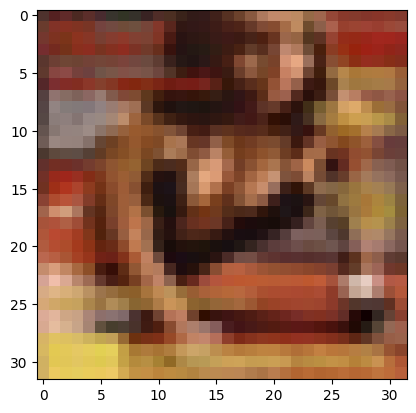

In [5]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14@336px', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[1654]
plt.imshow(image)


In [6]:
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

           shrew: 15.39%
           woman: 14.84%
            girl: 13.60%
    pickup_truck: 4.57%
          rabbit: 3.36%
